Replacing the "names" in for column names and rows and fixing the date

In [79]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("data/46241-0002_en_flat.csv", delimiter=";")
print(df.isnull().sum())

# Select relevant columns and rename them for clarity
df_cleaned = df.loc[:, [
    "time",  # Year
    "1_variable_attribute_label",  # Month
    "4_variable_attribute_label",  # Accident location
    "3_variable_attribute_label",  # Accident type
    "value"  # Number of accidents
]].rename(columns={
    "time": "Year",
    "1_variable_attribute_label": "Month",
    "4_variable_attribute_label": "Location",
    "3_variable_attribute_label": "Accident_Type",
    "value": "Accident_Count"
}).copy()  # Ensure we work on a separate DataFrame

# Forward-fill missing year values
df_cleaned["Year"] = df_cleaned["Year"].ffill()

# Replace missing values in other columns with "Unknown"
df_cleaned["Month"] = df_cleaned["Month"].fillna("Unknown")
df_cleaned["Location"] = df_cleaned["Location"].fillna("Unknown")
df_cleaned["Accident_Type"] = df_cleaned["Accident_Type"].fillna("Unknown")

# Convert data types
df_cleaned["Year"] = pd.to_numeric(df_cleaned["Year"], errors="coerce").astype("Int64")
df_cleaned["Accident_Count"] = pd.to_numeric(df_cleaned["Accident_Count"], errors="coerce").fillna(0).astype("Int64")

# Create a new column for Year (separate from the Date column)
df_cleaned["Year_Column"] = df_cleaned["Year"]

# Combine "Year" and "Month" into a single "Date" column
month_mapping = {
    "Januar": "January", "Februar": "February", "März": "March", "April": "April",
    "Mai": "May", "Juni": "June", "Juli": "July", "August": "August",
    "September": "September", "Oktober": "October", "November": "November", "Dezember": "December"
}
df_cleaned["Month"] = df_cleaned["Month"].replace(month_mapping)

# Create a new Date column and convert it to datetime format
df_cleaned["Date"] = pd.to_datetime(df_cleaned["Year"].astype(str) + "-" + df_cleaned["Month"], format="%Y-%B", errors="coerce")

# Categorize accident types into broader categories
def categorize_accident(acc_type):
    if "Personal injury" in acc_type:
        return "Personal Injury"
    if "mat.damage" in acc_type:
        return "Material Damage"
    if "intoxication" in acc_type:
        return "Intoxication"
    if "Other accidents involving material damage" in acc_type:
        return "Other Material Damage"
    if "Total" in acc_type:
        return "Total"
    return "Unknown"

df_cleaned["Accident_Category"] = df_cleaned["Accident_Type"].apply(categorize_accident)

# Drop original "Year" and "Month" columns, since "Date" now replaces them
df_cleaned = df_cleaned.drop(columns=["Year", "Month"])

# Save the cleaned dataset to a new CSV file
df_cleaned.to_csv("cleaned_traffic_accidents_with_separate_year.csv", index=True)

# Display a preview of the first 10 rows
df_cleaned.head()

statistics_code                 0
statistics_label                0
time_code                       0
time_label                      0
time                            0
1_variable_code                 0
1_variable_label                0
1_variable_attribute_code       0
1_variable_attribute_label      0
2_variable_code                 0
2_variable_label                0
2_variable_attribute_code       0
2_variable_attribute_label      0
3_variable_code                 0
3_variable_label                0
3_variable_attribute_code     668
3_variable_attribute_label      0
4_variable_code                 0
4_variable_label                0
4_variable_attribute_code     835
4_variable_attribute_label      0
value                           0
value_unit                      0
value_variable_code             0
value_variable_label            0
dtype: int64


,Location,Accident_Type,Accident_Count,Year_Column,Date,Accident_Category
0,Inside built-up areas,Personal injury accidents,14184,2024,2024-03-01,Personal Injury
1,Total,Personal injury accidents,24177,2024,2024-10-01,Personal Injury
2,Total,Other accidents involving intoxication,1226,2024,2024-09-01,Intoxication
3,On motorways/freeways,Total,14294,2024,2024-09-01,Total
4,Outside built-up areas (excl. motorways/freeways),Serious acc. invol. mat.damage in the nearer s...,2071,2024,2024-01-01,Material Damage


Starting with the actual timeseries analysis

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
df = pd.read_csv("cleaned_traffic_accidents_with_separate_year.csv", parse_dates=["Date"])

# Display a preview
df.head()

,Unnamed: 0,Location,Accident_Type,Accident_Count,Year_Column,Date,Accident_Category
0,0,Inside built-up areas,Personal injury accidents,14184,2024,2024-03-01,Personal Injury
1,1,Total,Personal injury accidents,24177,2024,2024-10-01,Personal Injury
2,2,Total,Other accidents involving intoxication,1226,2024,2024-09-01,Intoxication
3,3,On motorways/freeways,Total,14294,2024,2024-09-01,Total
4,4,Outside built-up areas (excl. motorways/freeways),Serious acc. invol. mat.damage in the nearer s...,2071,2024,2024-01-01,Material Damage


In [81]:
# Aggregate by month and location
df_location = df.groupby(["Date", "Location"])["Accident_Count"].sum().reset_index()

# Aggregate by month and accident type
df_accident_type = df.groupby(["Date", "Accident_Type"])["Accident_Count"].sum().reset_index()

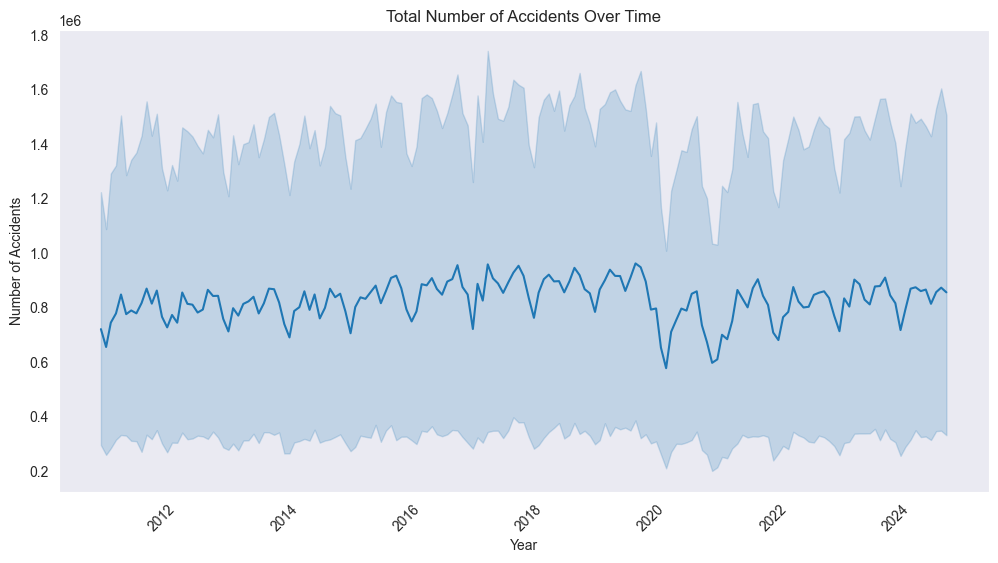

In [82]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="Date", y="Accident_Count", estimator="sum")
plt.title("Total Number of Accidents Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45)
plt.grid()
plt.show()

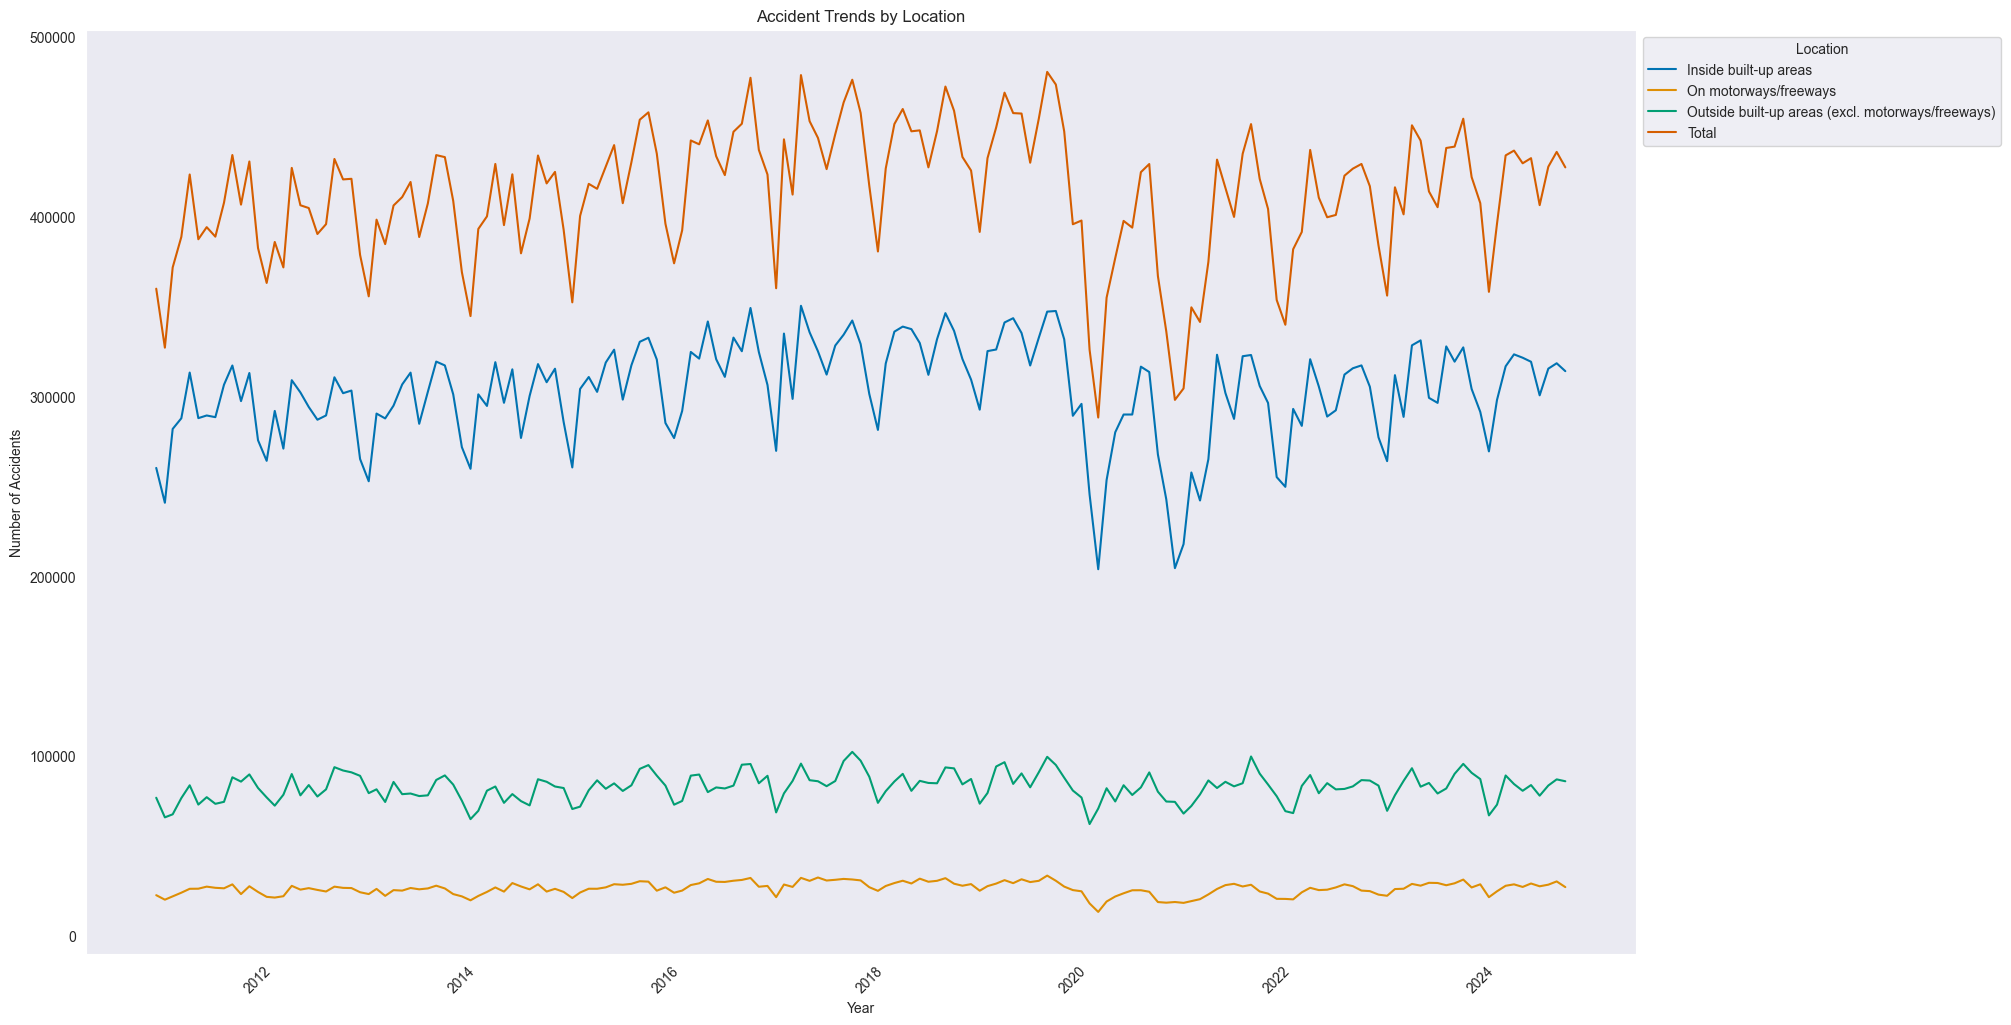

In [83]:
plt.figure(figsize=(20, 12))
sns.lineplot(data=df_location, x="Date", y="Accident_Count", hue="Location", palette='colorblind')
plt.title("Accident Trends by Location")
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45)
plt.legend(title="Location", bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

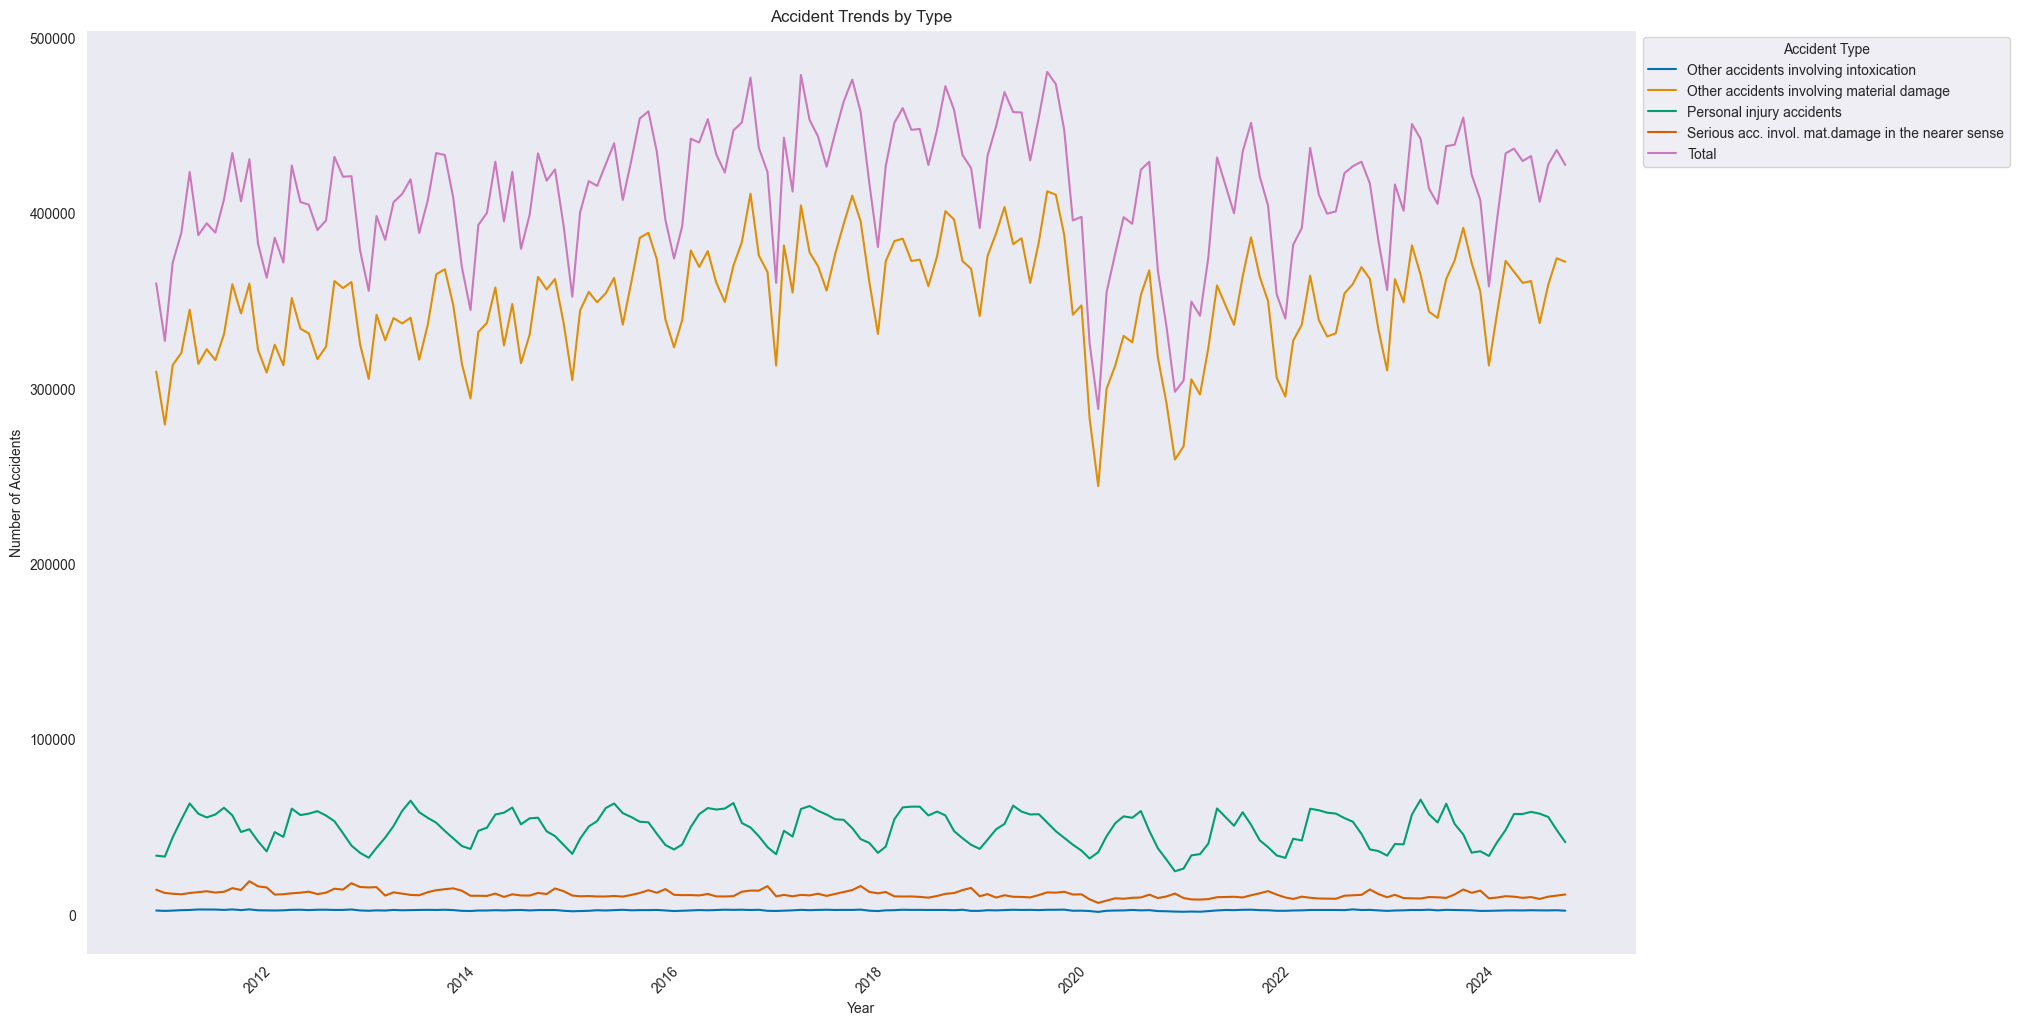

In [84]:
plt.figure(figsize=(20, 12))
sns.lineplot(data=df_accident_type, x="Date", y="Accident_Count", hue="Accident_Type", palette='colorblind')
plt.title("Accident Trends by Type")
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45)
plt.legend(title="Accident Type", bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

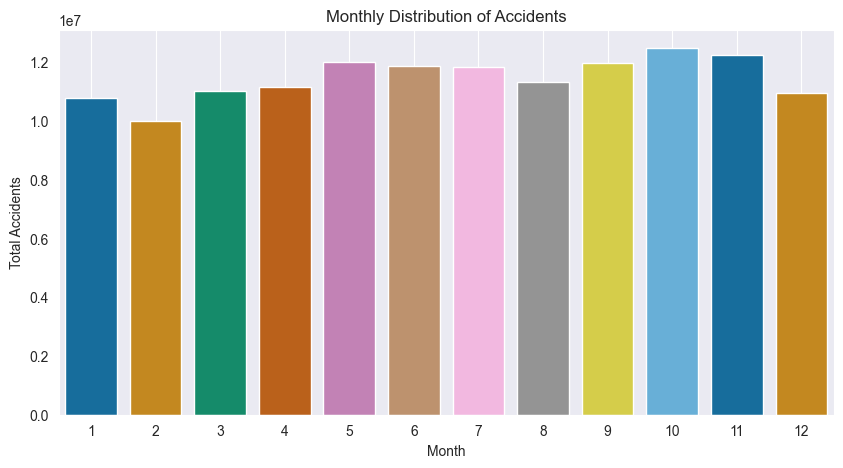

In [85]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df_monthly, x="Month", y="Accident_Count", hue="Month", palette="colorblind")

plt.title("Monthly Distribution of Accidents")
plt.xlabel("Month")
plt.ylabel("Total Accidents")
plt.grid()
plt.legend().remove()
plt.show()

We can see the lowest Amount of Accidents happens in February (due to it having less days than the other months)

Most Accidnets seem to happen in October which in germany most likely is connected to the "late" switch to winter tyres.
December has lower Accidents again, since a lot of people take some time off between christmas and New Year.

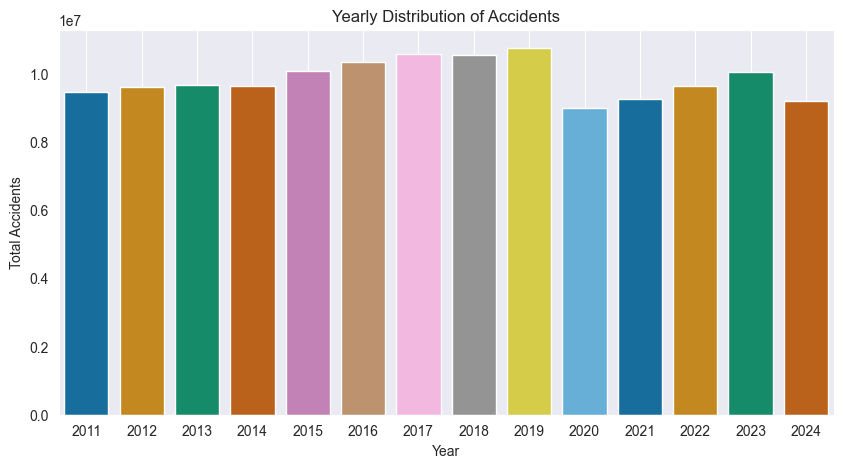

In [86]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df_yearly, x="Year", y="Accident_Count", hue="Year", palette="colorblind")

# Move the legend outside the plot
plt.legend(title="Year", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.title("Yearly Distribution of Accidents")
plt.xlabel("Year")
plt.ylabel("Total Accidents")
plt.grid()
plt.legend().remove()
plt.show()